<a href="https://colab.research.google.com/github/s1111e/ComputerVision/blob/main/Object_Detection_on_Tracking_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECTION 1 — Dataset Setup
In this part, we prepare the KITTI Tracking dataset.
We mount Google Drive, set folder paths, load images, load labels, and test the data.

In [ ]:
# 1. Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Define project folder
import os

PROJECT_ROOT = "/content/drive/My Drive/Colab Notebooks/CV Project"
DATA_ROOT    = os.path.join(PROJECT_ROOT, "Data/kitti_tracking")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT   :", DATA_ROOT)

IMAGE_DIR = os.path.join(DATA_ROOT, "data_tracking_image_2/training/image_02")
LABEL_DIR = os.path.join(DATA_ROOT, "data_tracking_label_2/training/label_02")
CALIB_DIR = os.path.join(DATA_ROOT, "data_tracking_calib/training/calib")

print("IMAGE_DIR:", IMAGE_DIR)
print("LABEL_DIR:", LABEL_DIR)
print("CALIB_DIR:", CALIB_DIR)

PROJECT_ROOT: /content/drive/My Drive/Colab Notebooks/CV Project
DATA_ROOT   : /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_tracking
IMAGE_DIR: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_tracking/data_tracking_image_2/training/image_02
LABEL_DIR: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_tracking/data_tracking_label_2/training/label_02
CALIB_DIR: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_tracking/data_tracking_calib/training/calib


In [ ]:
def load_kitti_tracking_labels(label_file):
    """
    Returns: dict {frame_id: [objects]}
    Each object: {"track_id":..., "class":..., "bbox":[x1,y1,x2,y2]}
    """
    annotations = {}

    with open(label_file, "r") as f:
        for line in f:
            p = line.strip().split()

            frame_id  = int(p[0])
            track_id  = int(p[1])
            cls       = p[2]
            x1,y1,x2,y2 = map(float, p[6:10])

            if frame_id not in annotations:
                annotations[frame_id] = []

            annotations[frame_id].append({
                "track_id": track_id,
                "class": cls,
                "bbox": [x1, y1, x2, y2]
            })

    return annotations


def draw_boxes(img, objects):
    img = img.copy()
    for obj in objects:
        x1,y1,x2,y2 = map(int, obj["bbox"])
        class_name  = obj["class"]
        track_id    = obj["track_id"]

        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, f"{class_name}:{track_id}",
                    (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255,0,0), 1)
    return img


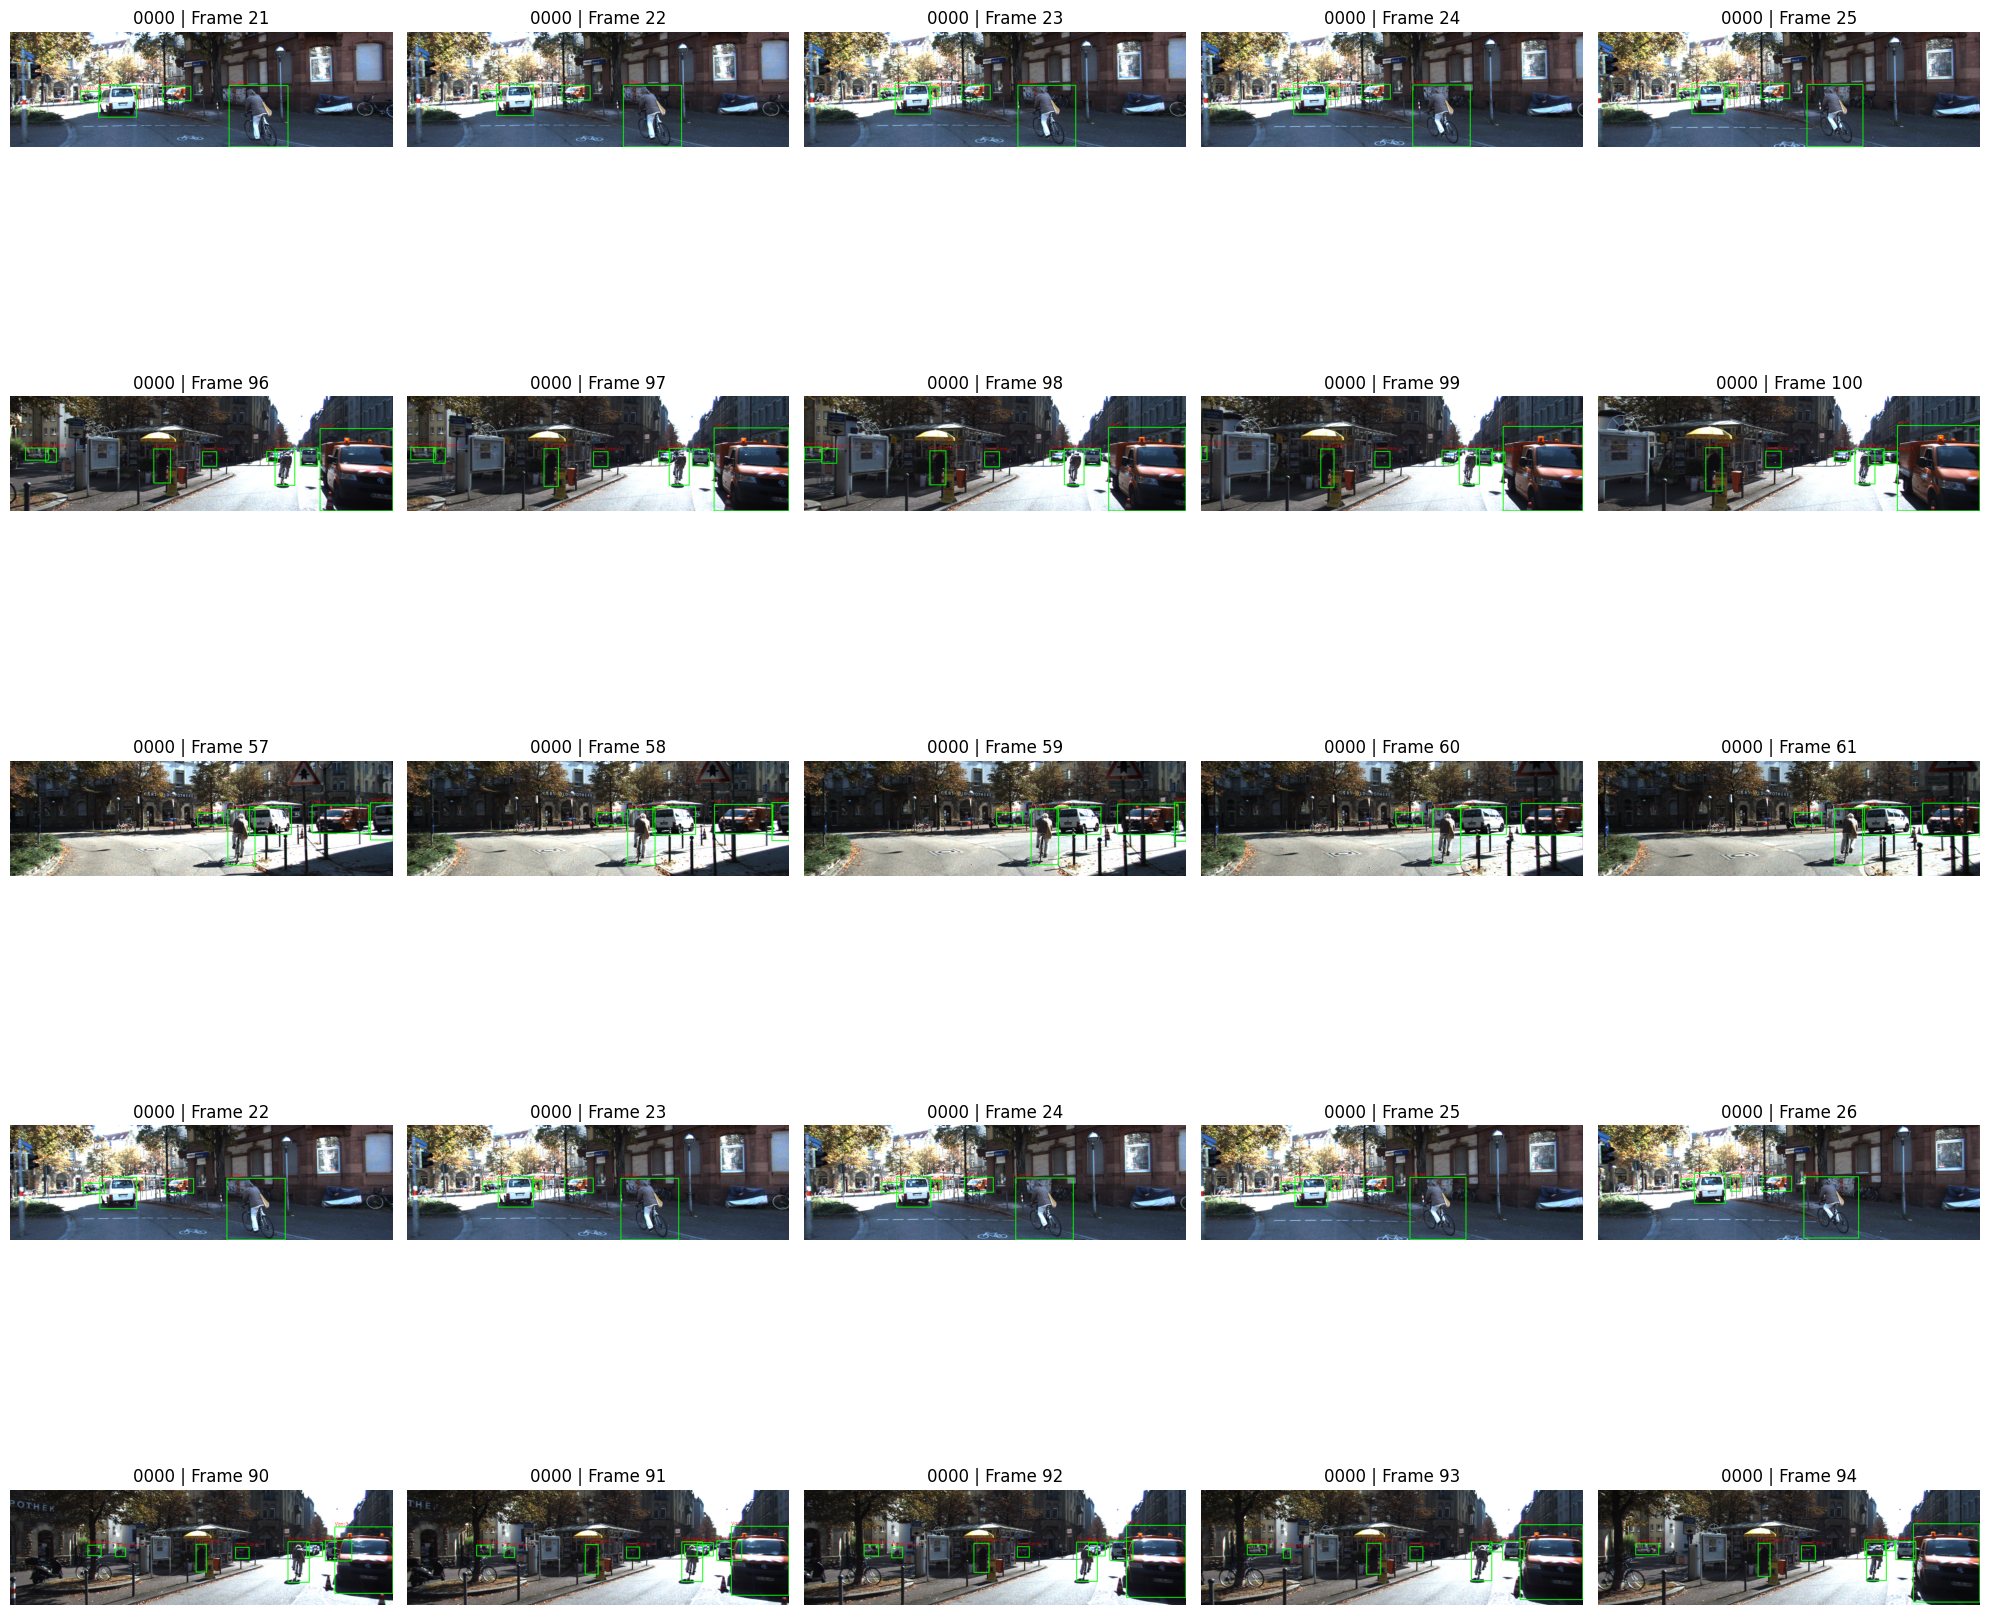

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
import os

def show_consecutive_frames(seq_id="0000", frames_per_row=5, num_rows=5):
    """
    Shows N rows, each row has 5 consecutive frames from the chosen sequence.
    """
    seq_path = os.path.join(IMAGE_DIR, seq_id)
    frame_files = sorted(os.listdir(seq_path))
    total_frames = len(frame_files)

    plt.figure(figsize=(20, 4 * num_rows))

    for row in range(num_rows):
        # pick random start index
        start_idx = random.randint(0, total_frames - frames_per_row)

        for col in range(frames_per_row):
            frame_name = frame_files[start_idx + col]
            frame_id = int(frame_name.split(".")[0])

            # load image
            img_path = os.path.join(seq_path, frame_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # load annotation for this frame
            label_file = os.path.join(LABEL_DIR, f"{seq_id}.txt")
            ann = load_kitti_tracking_labels(label_file)
            ann_frame = ann.get(frame_id, [])

            # draw GT boxes
            img_vis = draw_boxes(img_rgb, ann_frame)

            # plot
            idx = row * frames_per_row + col + 1
            plt.subplot(num_rows, frames_per_row, idx)
            plt.imshow(img_vis)
            plt.title(f"{seq_id} | Frame {frame_id}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()
show_consecutive_frames(seq_id="0000", frames_per_row=5, num_rows=5)


# SECTION 2 — Detection Models (4 Methods)

In this part, we run 4 different object detectors.
Two are one-stage, and two are two-stage models.
We run inference frame-by-frame and save detections.

1.   YOLO11 (one-stage)
2.   RetinaNet (one-stage)
3.   Faster R-CNN (two-stage)
4.   Mask R-CNN (two-stage)


In [ ]:
# 0.1 – Load image as tensor
import torch
import numpy as np
from torchvision import transforms

to_tensor = transforms.Compose([
    transforms.ToTensor()
])


# 0.2 – Convert torch output to standard format

def to_detection_list(pred_boxes, pred_scores, pred_labels, score_thresh=0.3):
    results = []
    for box, score, cls in zip(pred_boxes, pred_scores, pred_labels):
        if score >= score_thresh:
            x1, y1, x2, y2 = box.tolist()
            results.append([x1, y1, x2, y2, float(score), int(cls)])
    return results


# DETECTIONS SAVE FOLDER
DETECT_ROOT = os.path.join(PROJECT_ROOT, "Detections")
os.makedirs(DETECT_ROOT, exist_ok=True)

print("Detection Output Folder:", DETECT_ROOT)




Detection Output Folder: /content/drive/My Drive/Colab Notebooks/CV Project/Detections


In [ ]:
########    DETECTOR 1 — YOLO11 (One-Stage)


#1. Install Ultralytics
!pip install ultralytics
from ultralytics import YOLO


#2. Load YOLO11 model
model_yolo = YOLO("yolo11n.pt")  # fast version
# YOLO("yolo11s.pt") ## better accuracy
# YOLO("yolo11m.pt") ## strong, slower



# 3. YOLO inference function
import cv2

def run_yolo_on_frame(img_path, score_thresh=0.3):
    results = model_yolo(img_path, verbose=False)[0]
    dets = []
    for box in results.boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        score = float(box.conf)
        cls   = int(box.cls)
        if score >= score_thresh:
            dets.append([x1, y1, x2, y2, score, cls])
    return dets



#4. Run YOLO on all frames in a sequence
import json

def run_yolo_on_sequence(seq_id="0000"):
    output_path = os.path.join(DETECT_ROOT, f"YOLO11_{seq_id}.json")
    seq_path = os.path.join(IMAGE_DIR, seq_id)
    frames = sorted(os.listdir(seq_path))

    predictions = {}

    for f in frames:
        frame_path = os.path.join(seq_path, f)
        dets = run_yolo_on_frame(frame_path)
        frame_id = int(f.split(".")[0])
        predictions[frame_id] = dets

    with open(output_path, "w") as fp:
        json.dump(predictions, fp, indent=2)

    print("Saved:", output_path)





In [ ]:
#YOLO11 — Run ALL sequences
seq_list = sorted(os.listdir(IMAGE_DIR))

for seq in seq_list:
    print("Running YOLO11 on sequence:", seq)
    run_yolo_on_sequence(seq)

Running YOLO11 on sequence: 0000
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0000.json
Running YOLO11 on sequence: 0001
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0001.json
Running YOLO11 on sequence: 0002
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0002.json
Running YOLO11 on sequence: 0003
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0003.json
Running YOLO11 on sequence: 0004
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0004.json
Running YOLO11 on sequence: 0005
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0005.json
Running YOLO11 on sequence: 0006
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0006.json
Running YOLO11 on sequence: 0007
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/YOLO11_0007.json
Running YOLO11 on sequence: 0008
Saved: /content

In [ ]:
############## DETECTOR 2 — RetinaNet (One-Stage)

#1. Load RetinaNet
from torchvision.models.detection import retinanet_resnet50_fpn

model_retina = retinanet_resnet50_fpn(pretrained=True)
model_retina.eval().to("cuda")


#2. RetinaNet inference function
def run_retinanet_on_frame(img_path, score_thresh=0.3):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor = to_tensor(img_rgb).to("cuda")

    with torch.no_grad():
        out = model_retina([tensor])[0]

    dets = to_detection_list(
        out["boxes"].cpu(),
        out["scores"].cpu(),
        out["labels"].cpu(),
        score_thresh,
    )
    return dets

#3. Run RetinaNet on sequence
def run_retinanet_on_sequence(seq_id="0000"):
    output_path = os.path.join(DETECT_ROOT, f"RetinaNet_{seq_id}.json")

    seq_path = os.path.join(IMAGE_DIR, seq_id)
    frames = sorted(os.listdir(seq_path))
    predictions = {}

    for f in frames:
        img_path = os.path.join(seq_path, f)
        dets = run_retinanet_on_frame(img_path)
        frame_id = int(f.split(".")[0])
        predictions[frame_id] = dets

    with open(output_path, "w") as fp:
        json.dump(predictions, fp, indent=2)

    print("Saved:", output_path)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


100%|██████████| 130M/130M [00:00<00:00, 240MB/s]


In [ ]:
# RetinaNet — Run ALL sequences
seq_list = sorted(os.listdir(IMAGE_DIR))

for seq in seq_list:
    print("Running RetinaNet on sequence:", seq)
    run_retinanet_on_sequence(seq)

Running RetinaNet on sequence: 0000
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0000.json
Running RetinaNet on sequence: 0001
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0001.json
Running RetinaNet on sequence: 0002
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0002.json
Running RetinaNet on sequence: 0003
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0003.json
Running RetinaNet on sequence: 0004
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0004.json
Running RetinaNet on sequence: 0005
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0005.json
Running RetinaNet on sequence: 0006
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0006.json
Running RetinaNet on sequence: 0007
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/RetinaNet_0007.json


In [ ]:
########### DETECTOR 3 — Faster R-CNN (Two-Stage)


#Load Faster R-CNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model_frcnn = fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.eval().to("cuda")


#Faster R-CNN inference
def run_frcnn_on_frame(img_path, score_thresh=0.3):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor = to_tensor(img_rgb).to("cuda")

    with torch.no_grad():
        out = model_frcnn([tensor])[0]

    dets = to_detection_list(
        out["boxes"].cpu(),
        out["scores"].cpu(),
        out["labels"].cpu(),
        score_thresh,
    )
    return dets

#Run Faster R-CNN on sequence
def run_frcnn_on_sequence(seq_id="0000"):
    output_path = os.path.join(DETECT_ROOT, f"FRCNN_{seq_id}.json")

    seq_path = os.path.join(IMAGE_DIR, seq_id)
    frames = sorted(os.listdir(seq_path))
    predictions = {}

    for f in frames:
        img_path = os.path.join(seq_path, f)
        dets = run_frcnn_on_frame(img_path)
        frame_id = int(f.split(".")[0])
        predictions[frame_id] = dets

    with open(output_path, "w") as fp:
        json.dump(predictions, fp, indent=2)

    print("Saved:", output_path)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 241MB/s]


In [ ]:
#Faster R-CNN — Run ALL sequences

seq_list = sorted(os.listdir(IMAGE_DIR))

for seq in seq_list:
    print("Running FasterRCNN on sequence:", seq)
    run_frcnn_on_sequence(seq)


Running FasterRCNN on sequence: 0000
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0000.json
Running FasterRCNN on sequence: 0001
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0001.json
Running FasterRCNN on sequence: 0002
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0002.json
Running FasterRCNN on sequence: 0003
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0003.json
Running FasterRCNN on sequence: 0004
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0004.json
Running FasterRCNN on sequence: 0005
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0005.json
Running FasterRCNN on sequence: 0006
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0006.json
Running FasterRCNN on sequence: 0007
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/FRCNN_0007.json
Running FasterRCNN on se

In [ ]:
#DETECTOR 4 — Mask R-CNN (Two-Stage)

# Load Mask R-CNN

from torchvision.models.detection import maskrcnn_resnet50_fpn

model_mrcnn = maskrcnn_resnet50_fpn(pretrained=True)
model_mrcnn.eval().to("cuda")

#Mask R-CNN inference
def run_mrcnn_on_frame(img_path, score_thresh=0.3):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor = to_tensor(img_rgb).to("cuda")

    with torch.no_grad():
        out = model_mrcnn([tensor])[0]

    dets = to_detection_list(
        out["boxes"].cpu(),
        out["scores"].cpu(),
        out["labels"].cpu(),
        score_thresh,
    )
    return dets



#Run Mask R-CNN on sequence
def run_mrcnn_on_sequence(seq_id="0000"):
    output_path = os.path.join(DETECT_ROOT, f"MaskRCNN_{seq_id}.json")

    seq_path = os.path.join(IMAGE_DIR, seq_id)
    frames = sorted(os.listdir(seq_path))
    predictions = {}

    for f in frames:
        img_path = os.path.join(seq_path, f)
        dets = run_mrcnn_on_frame(img_path)
        frame_id = int(f.split(".")[0])
        predictions[frame_id] = dets

    with open(output_path, "w") as fp:
        json.dump(predictions, fp, indent=2)

    print("Saved:", output_path)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:00<00:00, 239MB/s]


In [ ]:
# Mask R-CNN — Run  ALL sequences

seq_list = sorted(os.listdir(IMAGE_DIR))

for seq in seq_list:
    print("Running MaskRCNN on sequence:", seq)
    run_mrcnn_on_sequence(seq)



Running MaskRCNN on sequence: 0000
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0000.json
Running MaskRCNN on sequence: 0001
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0001.json
Running MaskRCNN on sequence: 0002
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0002.json
Running MaskRCNN on sequence: 0003
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0003.json
Running MaskRCNN on sequence: 0004
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0004.json
Running MaskRCNN on sequence: 0005
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0005.json
Running MaskRCNN on sequence: 0006
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0006.json
Running MaskRCNN on sequence: 0007
Saved: /content/drive/My Drive/Colab Notebooks/CV Project/Detections/MaskRCNN_0007.json
Running MaskRCNN

In [ ]:
#####################
##################### BE CAREFUL --- MASTER PIPELINE which automatically runs all models in succession


####  IF YOU RUN EACH DETECTOR INDIVIDUALLY , YOU DONT NEED TO RUN THIS CELL

for model in [YOLO, RetinaNet, FasterRCNN, MaskRCNN]:
    for seq in all_sequences:
        run(model, seq)

# SECTION 3 — Detection Evaluation (mAP)
We compare model predictions with ground-truth and calculate IoU, precision-recall curves, AP and mAP

In [ ]:
# IoU Calculation

import numpy as np

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    unionArea = boxAArea + boxBArea - interArea

    if unionArea == 0:
        return 0.0
    return interArea / unionArea



# Load Ground-Truth for one sequence

def load_gt_for_sequence(seq_id):
    label_path = os.path.join(LABEL_DIR, f"{seq_id}.txt")
    ann = load_kitti_tracking_labels(label_path)

    # Convert GT → list of detection-like boxes
    # GT format: [x1, y1, x2, y2, class_id]
    gt_all = {}

    for frame_id, obj_list in ann.items():
        gt_all[frame_id] = get_detection_gt(obj_list)

    return gt_all

#Load detector predictions - we saved results in JSON earlier:


import json

def load_predictions(detector_name, seq_id):
    pred_path = os.path.join(DETECT_ROOT, f"{detector_name}_{seq_id}.json")

    with open(pred_path, "r") as fp:
        preds = json.load(fp)

    # Convert keys from string to int
    preds = {int(k): v for k, v in preds.items()}
    return preds



#Compute Precision-Recall & AP for one sequence
def evaluate_detector_on_sequence(detector_name, seq_id, iou_thresh=0.5):
    gt = load_gt_for_sequence(seq_id)
    preds = load_predictions(detector_name, seq_id)

    TP = 0
    FP = 0
    FN = 0

    for frame_id in gt.keys():
        gt_boxes = gt.get(frame_id, [])
        pred_boxes = preds.get(frame_id, [])

        matched_gt = set()

        for pb in pred_boxes:
            p_box = pb[:4]  # only bbox

            best_iou = 0
            best_gt_idx = -1

            for idx, gb in enumerate(gt_boxes):
                g_box = gb[:4]
                iou = compute_iou(p_box, g_box)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou >= iou_thresh:
                if best_gt_idx not in matched_gt:
                    TP += 1
                    matched_gt.add(best_gt_idx)
                else:
                    FP += 1  # multiple predictions for same object
            else:
                FP += 1

        FN += (len(gt_boxes) - len(matched_gt))

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "AP_approx": precision * recall  # simple approximation
    }




#Evaluate detector over ALL sequences → FULL mAP
def evaluate_detector(detector_name):
    seq_list = sorted(os.listdir(IMAGE_DIR))

    all_prec = []
    all_rec = []

    for seq in seq_list:
        print("Evaluating", detector_name, "on seq", seq)
        result = evaluate_detector_on_sequence(detector_name, seq)

        all_prec.append(result["precision"])
        all_rec.append(result["recall"])

    mAP = np.mean(np.array(all_prec) * np.array(all_rec))

    print("\n=== FINAL RESULT FOR", detector_name, "===")
    print("mAP:", mAP)
    print("______")
    print("______")

    return mAP


CLS_MAP = {"Car":1, "Pedestrian":2, "Cyclist":3}

def get_detection_gt(ann_frame):
    out = []
    for obj in ann_frame:
        cls = obj["class"]
        if cls not in CLS_MAP:
            continue
        x1,y1,x2,y2 = obj["bbox"]
        out.append([x1, y1, x2, y2, CLS_MAP[cls]])
    return out


In [ ]:
mAP_yolo      = evaluate_detector("YOLO11")
mAP_retina    = evaluate_detector("RetinaNet")
mAP_frcnn     = evaluate_detector("FRCNN")
mAP_maskrcnn  = evaluate_detector("MaskRCNN")

print("YOLO11 mAP:", mAP_yolo)
print("______")
print("RetinaNet mAP:", mAP_retina)
print("______")
print("FRCNN mAP:", mAP_frcnn)
print("______")
print("MaskRCNN mAP:", mAP_maskrcnn)


Evaluating YOLO11 on seq 0000
Evaluating YOLO11 on seq 0001
Evaluating YOLO11 on seq 0002
Evaluating YOLO11 on seq 0003
Evaluating YOLO11 on seq 0004
Evaluating YOLO11 on seq 0005
Evaluating YOLO11 on seq 0006
Evaluating YOLO11 on seq 0007
Evaluating YOLO11 on seq 0008
Evaluating YOLO11 on seq 0009
Evaluating YOLO11 on seq 0010
Evaluating YOLO11 on seq 0011
Evaluating YOLO11 on seq 0012
Evaluating YOLO11 on seq 0013
Evaluating YOLO11 on seq 0014
Evaluating YOLO11 on seq 0015
Evaluating YOLO11 on seq 0016
Evaluating YOLO11 on seq 0017
Evaluating YOLO11 on seq 0018
Evaluating YOLO11 on seq 0019
Evaluating YOLO11 on seq 0020

=== FINAL RESULT FOR YOLO11 ===
mAP: 0.3713351876056243
______
______
Evaluating RetinaNet on seq 0000
Evaluating RetinaNet on seq 0001
Evaluating RetinaNet on seq 0002
Evaluating RetinaNet on seq 0003
Evaluating RetinaNet on seq 0004
Evaluating RetinaNet on seq 0005
Evaluating RetinaNet on seq 0006
Evaluating RetinaNet on seq 0007
Evaluating RetinaNet on seq 0008
Ev